In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import itertools
from scipy.stats import chi2_contingency 
from scipy.stats.mstats import winsorize
from scipy.sparse import csr_matrix

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition  import TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.feature_extraction.text import  HashingVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC 
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

import xgboost
from xgboost import XGBClassifier

#from decision import plot_decision_regions
#from pipelines import extra_features

In [2]:
train=pd.read_csv('../Datasets/Train.csv')
test=pd.read_csv('../datasets/test.csv')

In [3]:
print(train.shape, test.shape)

(18506, 21) (6169, 20)


In [4]:
train.head(2)

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
0,tour_id1hffseyw,ITALY,45-64,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost
1,tour_idnacd7zag,UNITED KINGDOM,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,Yes,Yes,Yes,No,No,No,0,7,Yes,High Cost


In [5]:
test.loc[:, "cost_category"] = -1
test.tail(2)

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
6167,tour_idx80vbw5a,CANADA,18-24,Alone,1.0,0.0,Visiting Friends and Relatives,Wildlife Tourism,"Friends, relatives",Independent,...,No,No,No,No,No,No,21,0,No,-1
6168,tour_id8fkkwytb,KENYA,45-64,NaN,0.0,1.0,Meetings and Conference,Wildlife Tourism,"Friends, relatives",Independent,...,No,No,No,No,No,No,4,0,Yes,-1


In [6]:
#Checking if there's conflicting Tourist Ids in both datasets.
train['Tour_ID'].isin(test['Tour_ID']).sum()

0

In [7]:
df = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
df['main_activity'].replace({"Widlife Tourism": "Wildlife Tourism"}, inplace=True)
df['age_group'].replace({'<18':'1-17', '65+':'65-84'}, inplace=True)
#df.set_index('Tour_ID', inplace=True)
df.drop_duplicates(keep='first', inplace=True)

In [8]:
for col in df.select_dtypes(np.number):
    if col != ('total_male'):
        quartiles = np.percentile(df[col].fillna(df[col].median()), [25, 50, 75])
        mu = quartiles[1]
        sig = 0.74 * (quartiles[2] - quartiles[0])
        df.loc[:, col] = df.query(f'({col}.values > @mu - 3 * @sig) & ({col}.values < @mu + 3 * @sig)')
    else:
        df.loc[:, col] = df.query(f'({col}.values > @mu - 5 * @sig) & ({col}.values < @mu + 5 * @sig)')  

    df.loc[:, col] = df[col].fillna(df[col].median())

In [9]:
for age in df['age_group'].unique():
    freq = df.groupby(['age_group'])['Tour_ID'].count()
    l = np.array([0.5, 17.5, 24.5, 44.5, 64.5])
    u = np.array([17.5, 24.5, 44.5, 64.5, 84.5])
    c_interval = (u - l)
    fd = dict(freq / c_interval)

df['age_group'] =  df['age_group'].map(fd) 

In [10]:
mean = np.sum(df['age_group']) / len(df['age_group'])
df['age_group'] = mean - df['age_group'].values

In [11]:
df.columns

Index(['Tour_ID', 'country', 'age_group', 'travel_with', 'total_female',
       'total_male', 'purpose', 'main_activity', 'info_source',
       'tour_arrangement', 'package_transport_int', 'package_accomodation',
       'package_food', 'package_transport_tz', 'package_sightseeing',
       'package_guided_tour', 'package_insurance', 'night_mainland',
       'night_zanzibar', 'first_trip_tz', 'cost_category'],
      dtype='object')

In [12]:
df.eval('total_nights = night_mainland + night_zanzibar', inplace=True) 

#Length of stay on weekly basis
df['tour_duration'] = df['total_nights'].copy()
df['tour_duration'] /= 7

df.eval('total_people = total_male + total_female', inplace=True)
df['av_tmale_per_tp'] = df.groupby('total_people')['total_male'].transform('mean')
df['av_tfemale_per_tp'] = df.groupby(['total_people'])['total_female'].transform('mean')
df['av_tp_per_purpose'] = df.groupby(['purpose'])['total_people'].transform('mean')
df['info_source & purpose'] = df.groupby(['info_source', 'purpose'])['Tour_ID'].transform('count')
df['mean_age_density_per_country'] = df.groupby('country')['age_group'].transform('mean')
df['mean_age_density_per_main_activity'] = df.groupby('main_activity')['age_group'].transform('mean')
df['mean_age_density_per_info'] = df.groupby(['info_source'])['age_group'].transform('mean')

gender = []
for g in df[['total_people']]:
    result = df['total_male'].values - df['total_female'].values
    for i in result:
        if i > 0:
            gender.append('Male')
        elif i < 0:
            gender.append('Female')
        else:
            gender.append('Equal')
            
df['dominant_gender'] = gender
df['av_stay_per_gender'] = df.groupby(['dominant_gender'])['tour_duration'].transform('mean')

In [13]:
df.groupby(['dominant_gender'])['tour_duration'].transform('mean')#.plot(kind='hist')

0        1.018429
1        1.261611
2        1.261611
3        1.230981
4        1.018429
           ...   
24670    1.018429
24671    1.018429
24672    1.018429
24673    1.230981
24674    1.018429
Name: tour_duration, Length: 24675, dtype: float64

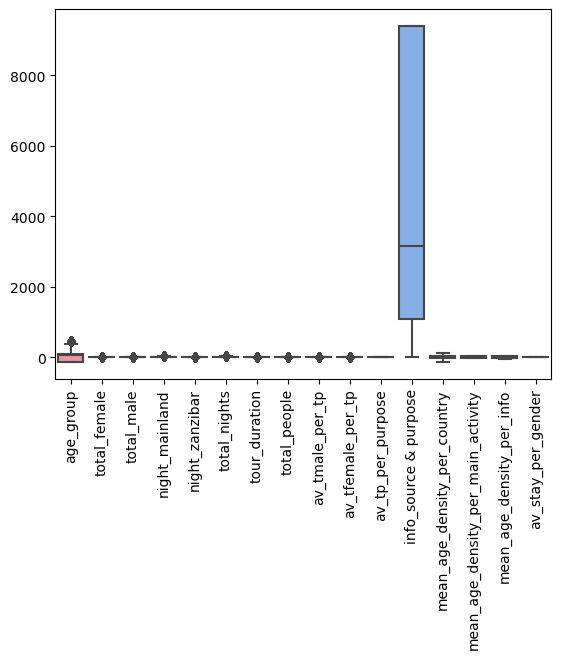

In [14]:
sns.boxplot(data=df)
plt.xticks(rotation=90);

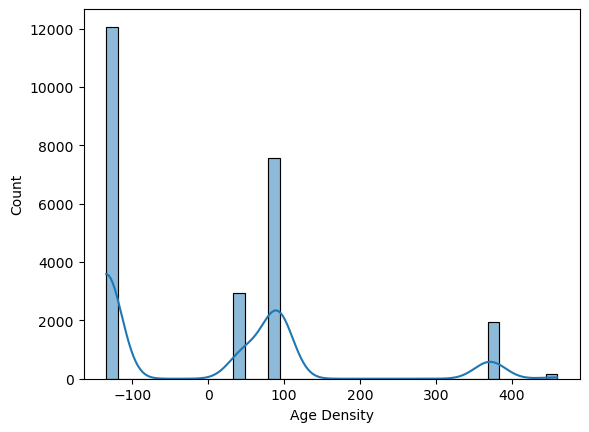

In [15]:
sns.histplot(df['age_group'], kde=True)
plt.xlabel('Age Density');

In [16]:
df.pivot_table('purpose', index='age_group', columns=['dominant_gender', 'tour_arrangement'], fill_value=0,
              aggfunc='count')#.apply(lambda x: np.mean(x))

dominant_gender        Equal                   Female               \
tour_arrangement Independent Package Tour Independent Package Tour   
age_group                                                            
-134.474965             1382         2585        1859         1235   
 47.353607               296          310         829          485   
 91.175035               645         2348         708         1059   
 371.575035              150          911          83          375   
 459.866212               11           27          34           33   

dominant_gender         Male               
tour_arrangement Independent Package Tour  
age_group                                  
-134.474965             3748         1259  
 47.353607               681          350  
 91.175035              1722         1073  
 371.575035              178          250  
 459.866212               25           24

In [17]:
df.pivot_table('purpose', index='dominant_gender', columns='age_group',
              aggfunc='count').apply(lambda x: np.mean(x))

age_group
-134.474965    4022.666667
 47.353607      983.666667
 91.175035     2518.333333
 371.575035     649.000000
 459.866212      51.333333
dtype: float64

In [18]:
np.sum(df['total_male'].values ** 2) / len(df['total_male'])

1.3456940222897669

In [19]:
df['total_male'].values ** 2

array([4., 1., 1., ..., 1., 0., 1.])

In [20]:
df.dominant_gender.value_counts() / len(df['dominant_gender'])

Male      0.377305
Equal     0.351165
Female    0.271530
Name: dominant_gender, dtype: float64

In [21]:
#train['age_category'] = train['age_group'].replace({'<18': 'young','18-24': 'young','25-44': 'middle_aged','45-64' : 'old','65+':'grands'})

#labels = ['three', 'five', 'week', 'ten', 'fortnight', 'month', 'year']
#bins = [0, 3, 5, 7, 10, 14, 21,  371]
#train['duration'] = pd.cut(train['total_nights'], bins=bins, labels=labels)

#labels = ['normal', 'minimal', 'nomini', 'big', 'grande']
#bins = [0, 1, 2, 3, 5, 93]
#df['travel_group_size'] = pd.cut(df['total_people'], bins=bins, labels=labels)

In [22]:
num_features = [col for col in df.select_dtypes(np.number)]
for f in num_features:
    #df["log_{}".format(f)] = (df[f] - df[f].min() + 1).transform(np.log)
    df.loc[:, f] = df[f].fillna(df[f].median())


cat_features = [] 
for x in df.select_dtypes('object', 'category'):
    df.loc[
        df['country'].value_counts()[df['country']].values < 20, "country"
    ] = "RARE"
    

    if x not in ('cost_category'):
        df.loc[:, x] = df[x].fillna("None").astype(str)
        cat_features.append(x)

        
com_features = []
combinations = list(itertools.combinations(com_features  , 2))
for f1, f2 in combinations:
    df.loc[:, f1 + "_" + f2 ] = df[f1].astype(str) + "_" + df[f2].astype(str) 
    cat_features.append(f1 + "_" + f2) 


In [23]:
len(num_features), len(cat_features)

(16, 16)

In [24]:
df.head()

,Tour_ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,...,total_people,av_tmale_per_tp,av_tfemale_per_tp,av_tp_per_purpose,info_source & purpose,mean_age_density_per_country,mean_age_density_per_main_activity,mean_age_density_per_info,dominant_gender,av_stay_per_gender
0,tour_id1hffseyw,ITALY,91.175035,With Children,0.0,2.0,Visiting Friends and Relatives,Beach Tourism,"Friends, relatives",Package Tour,...,2.0,0.977557,1.022443,1.518014,2457,-26.764593,-38.739830,-22.918575,Male,1.018429
1,tour_idnacd7zag,UNITED KINGDOM,-134.474965,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,2.0,0.977557,1.022443,1.972947,9409,2.348333,31.766373,28.312866,Equal,1.261611
2,tour_id62vz7e71,UNITED STATES OF AMERICA,371.575035,With Spouse,1.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,2.0,0.977557,1.022443,1.972947,9409,86.640775,31.766373,28.312866,Equal,1.261611
3,tour_idrc76tzix,RWANDA,-134.474965,With Spouse and Children,3.0,1.0,Leisure and Holidays,Beach Tourism,"Radio, TV, Web",Independent,...,4.0,2.074730,1.925270,1.972947,1092,-34.481939,-38.739830,-33.001695,Female,1.230981
4,tour_idn723m0n9,UNITED STATES OF AMERICA,91.175035,Alone,0.0,1.0,Leisure and Holidays,Wildlife Tourism,"Travel agent, tour operator",Package Tour,...,1.0,0.611608,0.388392,1.972947,9409,86.640775,31.766373,28.312866,Male,1.018429


In [25]:
def chi_test(X, y):
    col_drop= []
    not_drop= []
    undecided=[]
    
    for col in X.columns:
        ct=pd.crosstab(y, X[col])
        chi2, p, dof, expected = chi2_contingency(ct)
        
        if p >= 0.05 or chi2 <= 2000:
            col_drop.append(col)
        elif p < 0.05 and  chi2 >= 5000:
            not_drop.append(col)
        else:
            undecided.append(col)
        
        print(f"------------------------\nColumn: {col}\nChi Test: {chi2}\nP_Value: {p}\nDOF: {dof}\n------------------------")
    print(f"\n\nSUMMARY: \nLittle or No correlation Columns: {col_drop}\n\nCorrelation not so strong columns: {undecided}\n\nStrong Correlation Columns: {not_drop}")

In [26]:
train = df[df.cost_category != -1].reset_index(drop=True)
test = df[df.cost_category == -1].reset_index(drop=True)

In [27]:
test.to_csv('new_test.csv')

In [30]:
X =train.drop([ 'cost_category'], axis=1)
y = train['cost_category']

chi_test(X, y)

------------------------
Column: Tour_ID
Chi Test: 92530.0
P_Value: 0.4947449902995666
DOF: 92525
------------------------
------------------------
Column: country
Chi Test: 9401.22969371141
P_Value: 0.0
DOF: 300
------------------------
------------------------
Column: age_group
Chi Test: 1803.196457648891
P_Value: 0.0
DOF: 20
------------------------
------------------------
Column: travel_with
Chi Test: 4825.77958768553
P_Value: 0.0
DOF: 25
------------------------
------------------------
Column: total_female
Chi Test: 3135.1341596685616
P_Value: 0.0
DOF: 15
------------------------
------------------------
Column: total_male
Chi Test: 804.2466108839939
P_Value: 1.775590677605355e-157
DOF: 20
------------------------
------------------------
Column: purpose
Chi Test: 6975.312873617305
P_Value: 0.0
DOF: 35
------------------------
------------------------
Column: main_activity
Chi Test: 3606.50524881434
P_Value: 0.0
DOF: 40
------------------------
------------------------
Column: i

In [31]:
#checking total number of unique values in each column. 
def check_unique(df):
    for col in df:
        print(col, len(df[col].unique()))

check_unique(X)

Tour_ID 18506
country 61
age_group 5
travel_with 6
total_female 4
total_male 5
purpose 8
main_activity 9
info_source 8
tour_arrangement 2
package_transport_int 2
package_accomodation 2
package_food 2
package_transport_tz 2
package_sightseeing 2
package_guided_tour 2
package_insurance 2
night_mainland 24
night_zanzibar 9
first_trip_tz 2
total_nights 31
tour_duration 31
total_people 8
av_tmale_per_tp 8
av_tfemale_per_tp 8
av_tp_per_purpose 8
info_source & purpose 50
mean_age_density_per_country 106
mean_age_density_per_main_activity 9
mean_age_density_per_info 8
dominant_gender 3
av_stay_per_gender 3


In [32]:
#Checking and printing number of unique values in each categorical column
def cat_unique(df):
    for col in df.select_dtypes('object', 'category'):
        if df[col].nunique() > 20:
            print(f"\nColumn: {col}\nTotal number of Unique Values:  {df[col].nunique()}")
        else:
            print(f"\nColumn: {col}\nUnique Values: {df[col].nunique()}\n {df[col].unique()}")
            
cat_unique(X)


Column: Tour_ID
Total number of Unique Values:  18506

Column: country
Total number of Unique Values:  61

Column: travel_with
Unique Values: 6
 ['With Children' 'With Spouse' 'With Spouse and Children' 'Alone' 'None'
 'With Other Friends/Relatives']

Column: purpose
Unique Values: 8
 ['Visiting Friends and Relatives' 'Leisure and Holidays' 'Business'
 'Scientific and Academic' 'Meetings and Conference' 'Volunteering'
 'Other' 'Medical']

Column: main_activity
Unique Values: 9
 ['Beach Tourism' 'Wildlife Tourism' 'Cultural Tourism' 'Bird Tourism'
 'Hunting Tourism' 'Conference Tourism' 'Mountain Climbing' 'Business'
 'Diving and Sport Fishing']

Column: info_source
Unique Values: 8
 ['Friends, relatives' 'Travel agent, tour operator' 'Radio, TV, Web'
 'Newspaper, magazines, brochures' 'Others' 'Tanzania Mission Abroad'
 'Inflight magazines' 'Trade fair']

Column: tour_arrangement
Unique Values: 2
 ['Package Tour' 'Independent']

Column: package_transport_int
Unique Values: 2
 ['Yes' '

In [33]:
def showDetails(df):
    for col in df.select_dtypes('object', 'category') :
        if df[col].nunique() >= 20:
            print(f"{col} :\n {df[col].value_counts().reset_index(name= 'Total Count')[:10]}")
        else: 
            print('--------------------------------------------------------------------------')
            print(col)# + '& Cost Category')
            print(df[col].value_counts().reset_index(name="Total Count"))
            #tempDict = dict(df[col][df['cost_category'] == 'High Cost'].value_counts())
            #for i in tempDict.keys():
            #       tempDict[i] = ((tempDict[i]/len(df[df[col] == i]))*100).round(2)
            #print(tempDict)
            print('--------------------------------------------------------------------------')

showDetails(X)

Tour_ID :
              index  Total Count
0  tour_id1hffseyw            1
1  tour_idmewz05ax            1
2  tour_id1r5sg681            1
3  tour_idadk8knjo            1
4  tour_id8lpsjwla            1
5  tour_id0diqveca            1
6  tour_idfxt5l5d6            1
7  tour_idvxxrdp86            1
8  tour_id34b1jmya            1
9  tour_id97bpz9xl            1
country :
                       index  Total Count
0  UNITED STATES OF AMERICA         2846
1            UNITED KINGDOM         2120
2                     ITALY         1625
3                    FRANCE         1064
4                   GERMANY          969
5              SOUTH AFRICA          811
6                     KENYA          781
7                    ZAMBIA          715
8                 AUSTRALIA          704
9                    CANADA          571
--------------------------------------------------------------------------
travel_with
                          index  Total Count
0                         Alone         759

In [34]:
cat_features = [
    x for x in df.select_dtypes('object') if x not in ('Tour_ID', 'cost_category')
]

num_features = [n for n in df.select_dtypes(np.number)]

features = num_features + cat_features

In [35]:
col_drop= []
not_drop= []
undecided=[]

for col in train.columns:
    ct=pd.crosstab(train['cost_category'], train[col])
    chi2, p, dof, expected = chi2_contingency(ct)

    if p >= 0.05 or chi2 <= 2000:
        col_drop.append(col)
    elif p < 0.05 and  chi2 >= 3000:
        not_drop.append(col)
    else:
        undecided.append(col)

In [36]:
col_drop, undecided

(['Tour_ID', 'age_group', 'total_male', 'night_zanzibar'],
 ['package_insurance', 'first_trip_tz'])

In [37]:
drop = col_drop + undecided
X = train.drop(drop + ['cost_category'], axis=1)
#X = X.sample(frac=1)
y = train['cost_category']

In [38]:
mapping_age = {'0-17':1,
          '18-24':2 ,
          '25-44':3 ,
          '45-64':4,
          '65-100':5}

#X['age_group'] = X['age_group'].map(mapping_age).astype(np.float64)

le = LabelEncoder()
y = le.fit_transform(y)

In [39]:
cat_features = [
    x for x in X.select_dtypes('object') if x not in ('cost_category')
]

num_features = [n for n in X.select_dtypes(np.number)]

features = num_features + cat_features


num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False))
])

pipe = ColumnTransformer([
    ("numerical", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

tra = Pipeline([
    ("pipe", pipe),
    ("scaler", StandardScaler())

    #("svd", TruncatedSVD()))
])

X = tra.fit_transform(X)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, stratify=y,
                                                   random_state=123)

In [41]:
X_train.shape

(12954, 122)

In [42]:
fold = StratifiedKFold(n_splits=10, shuffle=True)

def run(clf):
    scores = []
    for f, (train_idx, valid_idx) in enumerate (fold.split(X, y)):
        X_train, X_test = X[train_idx], X[valid_idx]
        y_train, y_test = y[train_idx], y[valid_idx]

        model = clf

        model.fit(X_train, y_train)

        preds = model.predict_proba(X_test)

        auc = roc_auc_score(y_test, preds, multi_class='ovo')
        scores.append(auc)

        print("Fold%2d: AUC = %.4f " %(f+1, auc))

    print("\nScore: %.4f (+/- %.4f) " % (np.mean(scores), np.std(scores)))

In [43]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

nb = GaussianNB()
run(nb)

Fold 1: AUC = 0.6650 
Fold 2: AUC = 0.6633 
Fold 3: AUC = 0.6689 
Fold 4: AUC = 0.6476 
Fold 5: AUC = 0.6569 
Fold 6: AUC = 0.6468 
Fold 7: AUC = 0.6676 
Fold 8: AUC = 0.6508 
Fold 9: AUC = 0.6458 
Fold10: AUC = 0.6675 

Score: 0.6580 (+/- 0.0090) 


In [44]:
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.42      0.02      0.05      1103
 Higher Cost       0.47      0.01      0.02      1460
Highest Cost       0.03      0.97      0.05       108
    Low Cost       0.14      0.03      0.05       470
  Lower Cost       0.45      0.69      0.55       770
 Normal Cost       0.45      0.01      0.02      1641

    accuracy                           0.13      5552
   macro avg       0.33      0.29      0.12      5552
weighted avg       0.41      0.13      0.10      5552



In [45]:
lr = LogisticRegression(penalty='l2', C=0.1,
                        solver='lbfgs', multi_class='ovr',
                        max_iter=10000)
                        
run(lr)

Fold 1: AUC = 0.8172 
Fold 2: AUC = 0.8274 
Fold 3: AUC = 0.8235 
Fold 4: AUC = 0.8216 
Fold 5: AUC = 0.8185 
Fold 6: AUC = 0.8334 
Fold 7: AUC = 0.8359 
Fold 8: AUC = 0.8286 
Fold 9: AUC = 0.8254 
Fold10: AUC = 0.8334 

Score: 0.8265 (+/- 0.0061) 


In [46]:
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5493515850144092

In [47]:
lr.score(X_train, y_train)

0.5645360506407288

In [48]:
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.30      0.37      1103
           1       0.60      0.77      0.68      1460
           2       0.14      0.01      0.02       108
           3       0.12      0.00      0.00       470
           4       0.57      0.62      0.59       770
           5       0.52      0.68      0.59      1641

    accuracy                           0.55      5552
   macro avg       0.41      0.40      0.37      5552
weighted avg       0.50      0.55      0.51      5552



In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score
f1_score(y_test, y_pred, average='weighted')

0.5081589155564811

In [50]:
forest = RandomForestClassifier(n_estimators=300,
                                criterion='gini', 
                                random_state=123,
                                max_depth=6,
                                 n_jobs=-1)

run(forest)

Fold 1: AUC = 0.8257 
Fold 2: AUC = 0.8237 
Fold 3: AUC = 0.8262 
Fold 4: AUC = 0.8316 
Fold 5: AUC = 0.8268 
Fold 6: AUC = 0.8306 
Fold 7: AUC = 0.8240 
Fold 8: AUC = 0.8253 
Fold 9: AUC = 0.8327 
Fold10: AUC = 0.8280 

Score: 0.8275 (+/- 0.0030) 


In [51]:
forest.score(X_test, y_test)

0.5671829971181557

In [52]:
forest.score(X_train, y_train)

0.5669291338582677

In [53]:
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)

In [54]:
predictions = forest.predict_proba(X_test)
roc_auc_score(y_test, predictions, multi_class='ovr')

0.8377667990603372

In [55]:
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.52      0.32      0.40      1103
 Higher Cost       0.63      0.79      0.70      1460
Highest Cost       0.00      0.00      0.00       108
    Low Cost       0.00      0.00      0.00       470
  Lower Cost       0.56      0.53      0.55       770
 Normal Cost       0.51      0.71      0.60      1641

    accuracy                           0.56      5552
   macro avg       0.37      0.39      0.37      5552
weighted avg       0.50      0.56      0.51      5552



<Axes: >

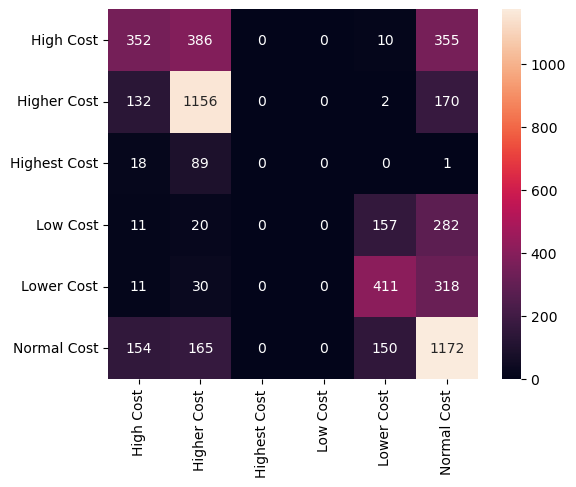

In [56]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d',
           xticklabels=le.classes_,
           yticklabels=le.classes_)

In [57]:
gr = SGDClassifier(loss='log_loss',
                   eta0=0.1,
                   learning_rate='optimal',
                  )

run(gr)

Fold 1: AUC = 0.8112 
Fold 2: AUC = 0.8055 
Fold 3: AUC = 0.7926 
Fold 4: AUC = 0.8035 
Fold 5: AUC = 0.8107 
Fold 6: AUC = 0.8098 
Fold 7: AUC = 0.8186 
Fold 8: AUC = 0.8027 
Fold 9: AUC = 0.8078 
Fold10: AUC = 0.7943 

Score: 0.8057 (+/- 0.0075) 


In [58]:
gr.fit(X_train, y_train)
predss = gr.predict_proba(X_test)
roc_auc_score(y_test, predss, multi_class='ovr')

0.8116871150121446

In [59]:
gr.score(X_test, y_test)

0.5315201729106628

In [60]:
gr.score(X_train, y_train)

0.5318048479234213

In [61]:
print(classification_report(y_test, gr.predict(X_test), target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.47      0.25      0.33      1103
 Higher Cost       0.59      0.79      0.67      1460
Highest Cost       0.20      0.03      0.05       108
    Low Cost       0.27      0.17      0.21       470
  Lower Cost       0.62      0.48      0.54       770
 Normal Cost       0.51      0.65      0.57      1641

    accuracy                           0.53      5552
   macro avg       0.44      0.40      0.40      5552
weighted avg       0.51      0.53      0.51      5552



In [62]:
lsv = LinearSVC(penalty='l2', loss='squared_hinge', C=0.1, class_weight='balanced',
          multi_class='ovr', random_state=123)

lsv.fit(X_train, y_train)
y_pred = lsv.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.46      0.32      0.38      1103
 Higher Cost       0.61      0.69      0.65      1460
Highest Cost       0.10      0.29      0.15       108
    Low Cost       0.21      0.09      0.12       470
  Lower Cost       0.52      0.64      0.58       770
 Normal Cost       0.55      0.55      0.55      1641

    accuracy                           0.51      5552
   macro avg       0.41      0.43      0.40      5552
weighted avg       0.50      0.51      0.50      5552



In [64]:
from catboost import CatBoostClassifier

cat = CatBoostClassifier(iterations=100,
                         learning_rate=0.1,
                         max_depth=8,
                         logging_level='Silent',
                         random_state=123)
run(cat)

Fold 1: AUC = 0.8483 
Fold 2: AUC = 0.8416 
Fold 3: AUC = 0.8332 
Fold 4: AUC = 0.8509 
Fold 5: AUC = 0.8330 
Fold 6: AUC = 0.8369 
Fold 7: AUC = 0.8372 
Fold 8: AUC = 0.8475 
Fold 9: AUC = 0.8314 
Fold10: AUC = 0.8389 

Score: 0.8399 (+/- 0.0066) 


In [65]:
cat.fit(X_train, y_train)

y_pred = cat.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.52      0.34      0.41      1103
 Higher Cost       0.64      0.77      0.70      1460
Highest Cost       0.00      0.00      0.00       108
    Low Cost       0.26      0.02      0.04       470
  Lower Cost       0.57      0.63      0.60       770
 Normal Cost       0.53      0.71      0.61      1641

    accuracy                           0.57      5552
   macro avg       0.42      0.41      0.39      5552
weighted avg       0.53      0.57      0.53      5552



In [70]:
preds = cat.predict_proba(X_test)
print(roc_auc_score(y_test, preds, multi_class='ovr'))

0.8478779593687337


<Axes: >

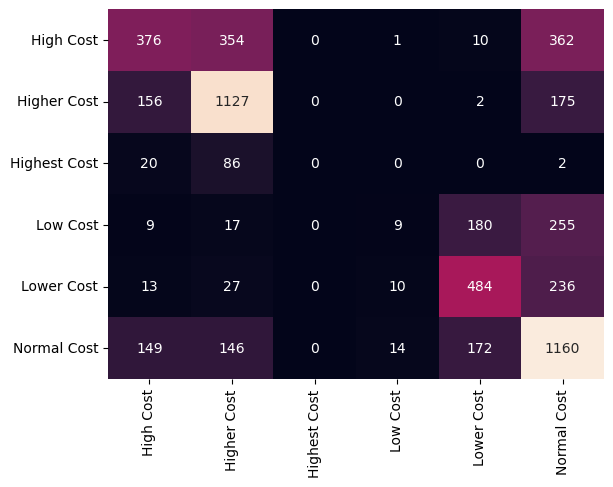

In [71]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cbar=False,
           xticklabels=le.classes_,
           yticklabels=le.classes_)

In [72]:
xgb  = XGBClassifier(n_estimators=200,
                    max_depth=8, n_jobs=-1)

run(xgb)

Fold 1: AUC = 0.8351 
Fold 2: AUC = 0.8277 
Fold 3: AUC = 0.8338 
Fold 4: AUC = 0.8224 
Fold 5: AUC = 0.8224 
Fold 6: AUC = 0.8246 
Fold 7: AUC = 0.8296 
Fold 8: AUC = 0.8220 
Fold 9: AUC = 0.8211 
Fold10: AUC = 0.8322 

Score: 0.8271 (+/- 0.0050) 


In [78]:
#xgb.fit(X_train, y_train)
predss = xgb.predict_proba(X_test)
roc_auc_score(y_test, predss, multi_class='ovr')

0.9721017835224798

In [79]:
xgb.score(X_test, y_test)

0.8335734870317003

In [80]:
xgb.score(X_train, y_train)

0.8349544542226339

In [84]:
print(classification_report(y_test, xgb.predict(X_test), target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.86      0.76      0.81      1103
 Higher Cost       0.84      0.93      0.88      1460
Highest Cost       0.82      0.73      0.77       108
    Low Cost       0.84      0.61      0.71       470
  Lower Cost       0.80      0.86      0.83       770
 Normal Cost       0.82      0.86      0.84      1641

    accuracy                           0.83      5552
   macro avg       0.83      0.79      0.81      5552
weighted avg       0.83      0.83      0.83      5552



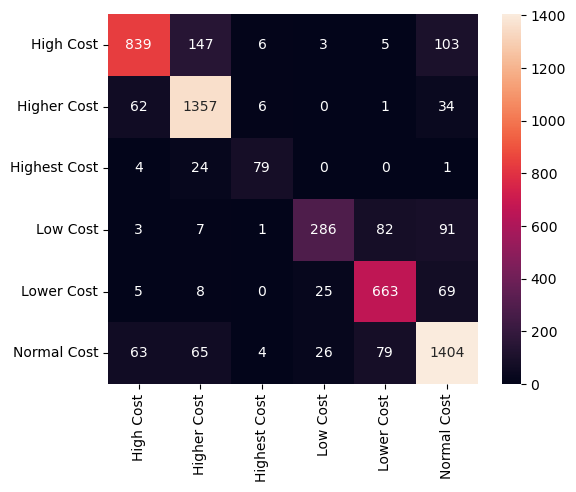

In [83]:
cm = confusion_matrix(y_test, xgb.predict(X_test))
sns.heatmap(cm, square=True, annot=True, fmt='d',
           xticklabels=le.classes_,
           yticklabels=le.classes_);

In [85]:
train.to_csv('train.csv')

In [87]:
from sklearn.metrics import make_scorer
scorer = make_scorer(roc_auc_score, 
                     greater_is_better=True, needs_proba=True)

gs = GridSearchCV(estimator=cat,
                 param_grid=[{
                     "iterations":[150, 200, 300],
                     "max_depth":[1, 2, 3, 4, 5, 6, 7],
                     "learning_rate": [0.01, 0.1, 1],
                     "logging_level": ['Silent'],
                 }],
                 cv=2, scoring='roc_auc_ovr', n_jobs=-1, verbose=1)

gs.fit(X_train, y_train)

Fitting 2 folds for each of 63 candidates, totalling 126 fits


GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000020BE3DA7220>,
             n_jobs=-1,
             param_grid=[{'iterations': [150, 200, 300],
                          'learning_rate': [0.01, 0.1, 1],
                          'logging_level': ['Silent'],
                          'max_depth': [1, 2, 3, 4, 5, 6, 7]}],
             scoring='roc_auc_ovr', verbose=1)

In [88]:
scores = cross_val_score(gs, X_train, y_train,
                       cv=5, scoring='roc_auc_ovr')

print("AUC Score: %.3f (+/- %.3f)" % (np.mean(scores),
                                     np.std(scores)))

Fitting 2 folds for each of 63 candidates, totalling 126 fits
Fitting 2 folds for each of 63 candidates, totalling 126 fits
Fitting 2 folds for each of 63 candidates, totalling 126 fits
Fitting 2 folds for each of 63 candidates, totalling 126 fits
Fitting 2 folds for each of 63 candidates, totalling 126 fits
AUC Score: 0.841 (+/- 0.009)


In [89]:
gs.best_params_

{'iterations': 300,
 'learning_rate': 0.1,
 'logging_level': 'Silent',
 'max_depth': 4}

In [91]:
gs.best_score_

0.8380971444758205

In [ ]:
def model_selection(classifier): 
    gs = GridSearchCV(estimator=classifier,
                 param_grid=[{
                     "n_estimators":[ 200, 300, None],
                     "max_depth":[1, 2, 3,
                                  4, 7, None],
                     "criterion":['gini', 'entropy', 'log_loss']
                 }],
                 cv=2, scoring='roc_auc', n_jobs=-1, verbose=1)

    gs.fit(X_train, y_train)
    
    scores = cross_val_score(gs, X_train, y_train,
                       cv=5, scoring='roc_auc')

    print('AUC Score: %.3f (+/- %.3f' % (np.mean(scores),
                                         np.std(scores)))

In [ ]:
model_selection(forest)

In [ ]:
model_selection(xgb)

In [ ]:
importances = forest.feature_importances_
imp = np.argsort(importances)
imp

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
for x in df.select_dtypes('object'):
    if x not in ['Tour_ID']:
        if df[x].nunique() >= 30:
            vect = HashingVectorizer(n_features = 2**8,
                                     encoding='iso-8859-1',
                                     decode_error="ignore",
                                     lowercase=False,
                                     binary=True)

            xx = vect.fit_transform(df[x])
            xx = pd.DataFrame(xx.toarray()).assign(x = df[x].values)
            display(xx)

In [ ]:
train['total_male'].values != train['total_female'].values

In [ ]:
g = []
for col in train.columns:
    if (train['total_male'].values > train['total_female'].values) == True:
        g.append('M')
    else:
        g.append('F')

In [ ]:
train['total_people']=train['total_male'] + train['total_female']
train['total_nights']=train['night_zanzibar']+train['night_mainland']
train['average_stay']= (train['total_people'] / train['total_nights']).round(2)
train['age_category'] = train['age_group'].replace({'0-18': 'young',
                                                   '18-24': 'young',
                                                   '25-44': 'middle_aged',
                                                   '45-64' : 'old',
                                                   '65-100':'grands'})

labels = ['three', 'five', 'week', 'ten', 'fortnight', 'month', 'year']
bins = [0, 3, 5, 7, 10, 14, 21,  371]
train['stay_length'] = pd.cut(train['total_nights'], bins=bins, labels=labels)

labels = ['normal', 'minimal', 'nomini', 'big', 'grande']
bins = [0, 1, 2, 3, 5, 93]
train['travel_group'] = pd.cut(train['total_people'], bins=bins, labels=labels)

#train['']

In [237]:
def check_outliers(data, factor:int, strategy='median', inplace=True):
    for col in data.select_dtypes(include=['int', 'float']).columns:
        lower_qtl = data[col].quantile(0.25)
        upper_qtl=data[col].quantile(0.75)
        iqr=(upper_qtl-lower_qtl)
        u_bound= upper_qtl + factor * iqr
        l_bound= lower_qtl - factor * iqr
        
        outliers=[] 
        for x in data[col]:
            if ((x > u_bound) or (x  < l_bound)):
                outliers.append(x)
                
        if strategy == 'mean':
            replacement = data[col].mean()
        elif strategy == 'median':
            replacement = data[col].median()
        elif strategy == 'mode':
            replacement = data[col].mode()[0]
            
        for idx in outliers:
            data.loc[idx,col]=replacement
        
        print(f"\n\nColumn: {col}\nLower_Bound: {l_bound}\nUpper_Bound: {u_bound}\nOutliers: {outliers}")
    
    print(f"\n\n\nOutliers Succesfully replaced with {strategy}.")

In [239]:
%%time
check_outliers(df,factor=3, strategy='median', inplace=True)



Column: total_female
Lower_Bound: -3.0
Upper_Bound: 4.0
Outliers: []


Column: total_male
Lower_Bound: 1.0
Upper_Bound: 1.0
Outliers: [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 4.0, 2.0, 0.0, 0.0, 3.0, 0.0, 3.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 3.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 3.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 0.0, 3.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 3.0, 2.0, 0.0, 3.0, 0.0, 3.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.0, 2.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 4.0, 0.0, 0.0, 2.0, 0.0, 0.0, 4.0, 0.0



Column: average_stay_per_person
Lower_Bound: -0.43000000000000005
Upper_Bound: 0.9000000000000001
Outliers: [1.33, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.33, 1.0, 1.0, 1.5, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.25, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.33, 1.0, 1.0, 1.5, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.5, 2.0, 1.0, 1.0, 1.33, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.33, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.33, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.5, 1.0, 2.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.33, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.5, 1.0, 1.2, 1.67, 1.0, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.33, 1.67

In [ ]:
mapping = {'0-17':1,
          '18-24':2 ,
          '25-44':3 ,
          '45-64':4,
          '65-100':5}

df['age_group'] = df['age_group'].map(mapping).astype(np.float64)
df.head()

In [ ]:
obs_vars = df.groupby('main_activity').mean().var()[0]
print("Observed mean: ", df.groupby('main_activity').mean().values.ravel())

In [ ]:
print("Observed Variance: ", obs_vars)

In [ ]:
def perm_test(df):
    df = train.copy()
    df['total_people'] = np.random.permutation(df['total_male'].values)
    
    return df.groupby('main_activity').mean().var()[0]

perm_variance = [perm_test(df) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > obs_vars for var in perm_variance]))

In [ ]:
df.to_csv('new.csv')